### Bhavesh Hiranand Chainani
#### Silent Eight Data Science Assessment

In [74]:
## Import all relevant python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE 

In [75]:
## Read in data
data = pd.read_csv('data/all_trxns.csv')

### Exploratory Data Analysis (EDA)

In [76]:
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35


In [77]:
data.shape
# 5302 rows, 9 columns

(5302, 9)

In [46]:
data.dtypes

customer                object
customer_country        object
fraud_flag              object
timestamp               object
counterparty             int64
counterparty_country    object
type                    object
ccy                     object
amount                  object
dtype: object

In [47]:
data.describe()

,counterparty
count,5.302000e+03
mean,5.626952e+13
std,2.609480e+13
min,1.136138e+13
25%,3.259593e+13
50%,5.715527e+13
75%,7.748636e+13
max,9.972984e+13


In [48]:
## We notice that the timestamp column is a string, hence it is important to convert it to datetime format
type(data['timestamp'][0])

str

In [49]:
## convert timestamp column from string to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [50]:
## Identify any null values
data.isna().sum()

customer                  0
customer_country          0
fraud_flag                0
timestamp                 0
counterparty              0
counterparty_country    499
type                      0
ccy                       0
amount                    0
dtype: int64

In [51]:
# We can see the counterparty_country is the only column with null values. 
# We will leave it for now as we do not want to remove any uneccessary rows, 
# given that the dataset is relatively small.

In [52]:
# remove unneccessary strings from amount column (e.g 1,712 to 1712) 
data['amount'] = data['amount'].str.replace('[,$£]','')
# convert amount column to float
data['amount'] = data['amount'].astype(float)

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_47205/656557539.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['amount'] = data['amount'].str.replace('[,$£]','')


In [53]:
data.amount.describe()

count    5.302000e+03
mean     5.043384e+05
std      1.546262e+06
min      9.911000e+01
25%      2.707183e+04
50%      5.163731e+04
75%      1.004043e+05
max      1.277252e+07
Name: amount, dtype: float64

## Relevant Visualisations

In [55]:
## We notice that customers are repeated, hence for visualisation purposes, 
# we will focus on distinct customers

data_cust = data.drop_duplicates(subset=['customer', 'customer_country']).reset_index(drop=True)

In [56]:
data_cust.shape
## there are 100 distinct customers

(100, 9)

<AxesSubplot: >

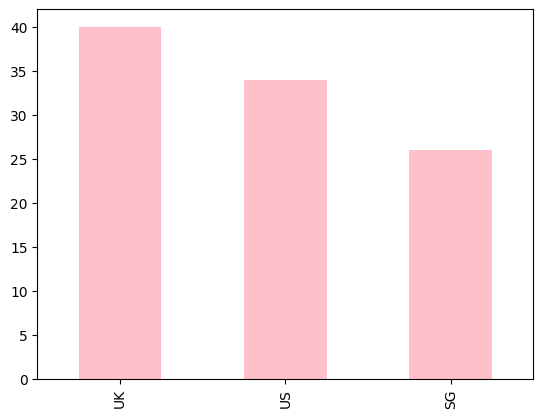

In [57]:
#plot customer country for the 100 customers (data_vis df)
data_cust.customer_country.value_counts().plot(kind='bar', color='pink')

In [58]:
## Counterparty Country

data.counterparty_country.value_counts().to_frame()

## We can see that United States, US and USA are included. 
## Hence, there is a need to change United States, US to USA

,counterparty_country
CN,619
UK,614
JP,537
US,494
DE,484
FR,455
HK,453
BR,392
SG,375
IN,340


In [59]:
data['counterparty_country'] = data['counterparty_country'].replace(['United States', 'US'], 'USA')

<AxesSubplot: title={'center': 'Total Number of Customers per Country'}>

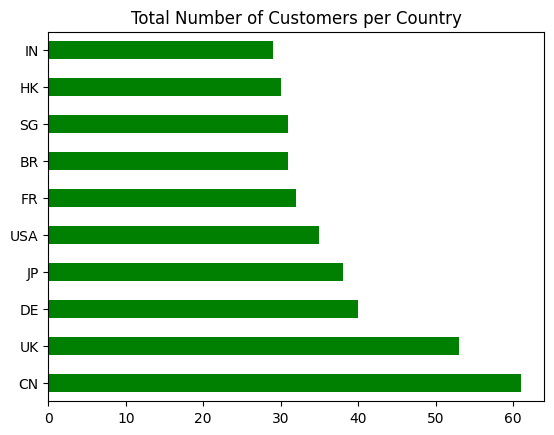

In [62]:
#plot counterparty country based on unique counterparties
data.drop_duplicates(subset=['counterparty','counterparty_country']).reset_index(drop=True).counterparty_country.value_counts().plot(kind='barh', color = 'green', title='Total Number of Customers per Country')

<AxesSubplot: >

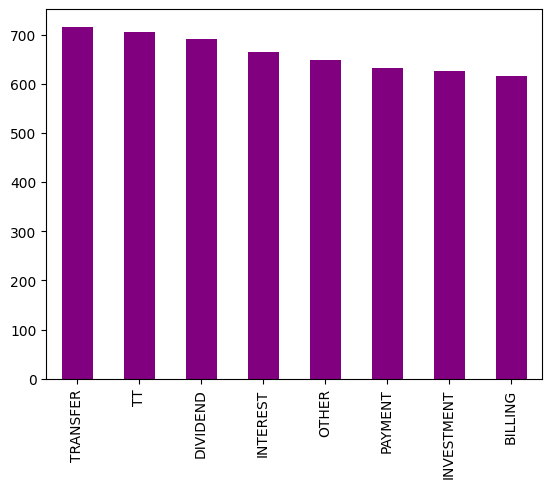

In [63]:
#plot count of different transaction types
data.type.value_counts().plot(kind='bar', color = 'purple')

<AxesSubplot: >

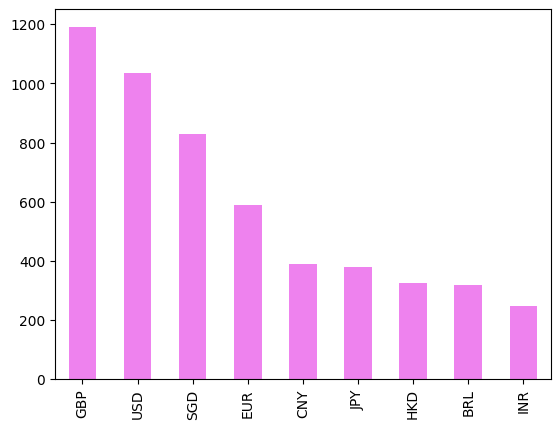

In [64]:
#plot count of types of currency
data.ccy.value_counts().plot(kind='bar', color = 'violet')

<AxesSubplot: >

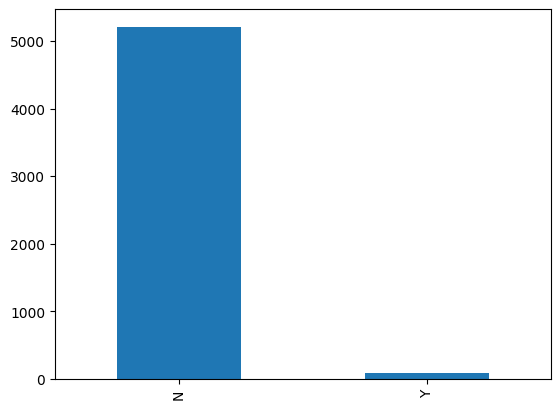

In [65]:
#plot value counts of y label
data.fraud_flag.value_counts().plot(kind='bar')

In [66]:
## Since y value is low, we can do oversampling on minority class to increase model performance

<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

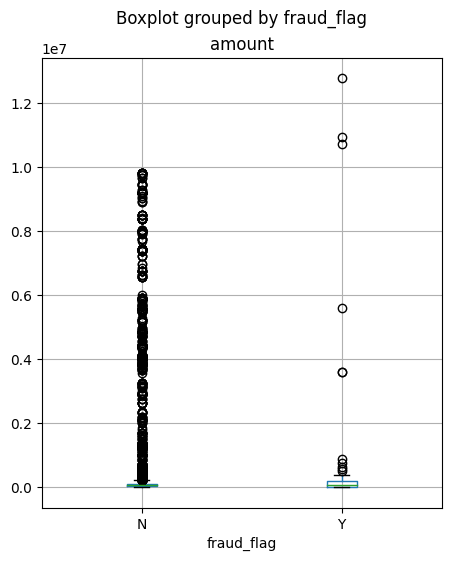

In [67]:
#box plot of relationship between fraud_flag and amount
data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

In [68]:
## create new column for month year
data['month_year'] = pd.to_datetime(data['timestamp']).dt.to_period('M')
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09


<AxesSubplot: xlabel='month_year'>

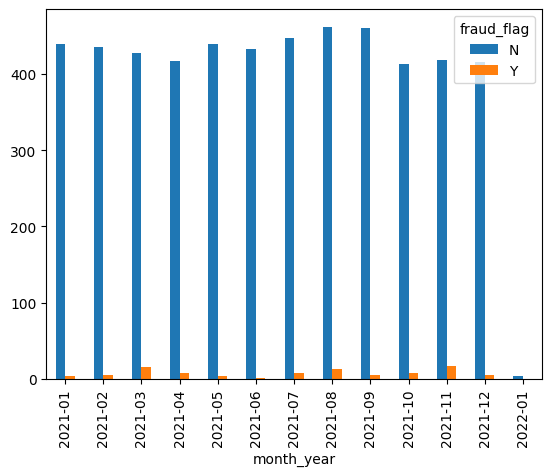

In [69]:
## Visualise distribution of y value for each month
(data
 .groupby(['month_year', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar()
)

### Modelling

In [167]:
## Model 1: use counterparty_country and drop NaN values
## Model 2: don't use counterparty_country (ignoring null values)

In [71]:
## Model 1

## We keep the counterparty_country as one of our features in the model. Hence we remove the NaN values
## and therefore remove the 499 missing values

In [72]:
data = data.dropna().reset_index(drop=True)

In [73]:
data.corr()

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_47205/2579876458.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_model1.corr()


,counterparty,amount
counterparty,1.000000,-0.035139
amount,-0.035139,1.000000


In [170]:
## data cleaning, remapping, SMOTE

In [171]:
## REMAP to integers
data['fraud_flag'] = [0 if x == 'N' else 1 for x in data['fraud_flag']]

In [173]:
# Create dummy variables
dummy_customer_country = pd.get_dummies(data['customer_country'], prefix='cust_country', drop_first=True)
dummy_counterparty_country = pd.get_dummies(data['counterparty_country'], prefix='count_country', drop_first=True)
dummy_type = pd.get_dummies(data['type'], prefix='type', drop_first=True)
dummy_ccy = pd.get_dummies(data['ccy'], prefix='ccy', drop_first=True) 

In [174]:
dummy_counterparty_country

,count_country_CN,count_country_DE,count_country_FR,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4798,0,0,0,0,0,0,0,1,0
4799,0,0,0,0,0,0,0,1,0
4800,0,0,0,0,0,0,0,1,0
4801,0,0,0,0,0,0,0,1,0


In [176]:
# Drop unnecessary columns
to_drop = ['customer', 'customer_country', 'timestamp', 'counterparty',
           'counterparty_country', 'type', 'ccy','month_year']
data.drop(to_drop, axis=1, inplace=True)

In [177]:
data

,fraud_flag,amount
0,0,48625.25
1,0,20637.21
2,0,36944.25
3,0,48653.70
4,0,48765.81
...,...,...
4798,0,25451.05
4799,0,25774.25
4800,0,25660.33
4801,0,32242.92


In [178]:
# Merge into a single data frame
merged_df = pd.concat([dummy_ccy,dummy_type,dummy_counterparty_country,dummy_customer_country,data], axis=1)
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48625.25
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,20637.21
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,36944.25
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48653.70
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48765.81


In [179]:
## use MinMaxScaler to handle the large values of amount, 
## since  machine learning algorithms will give more importance to variables on a larger scale

# Scale only columns that have values greater than 1
to_scale = [col for col in data.columns if data[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged_df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged_df[col] = scaled[col]
    
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003799
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.001608
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.002885
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003802
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003810


In [180]:
## create model using SMOTE

## Naive Approach

X = merged_df.drop('fraud_flag', axis=1)
y = merged_df['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.69
% Positive class in Test  = 1.67


Accuracy = 0.99
Recall = 0.40



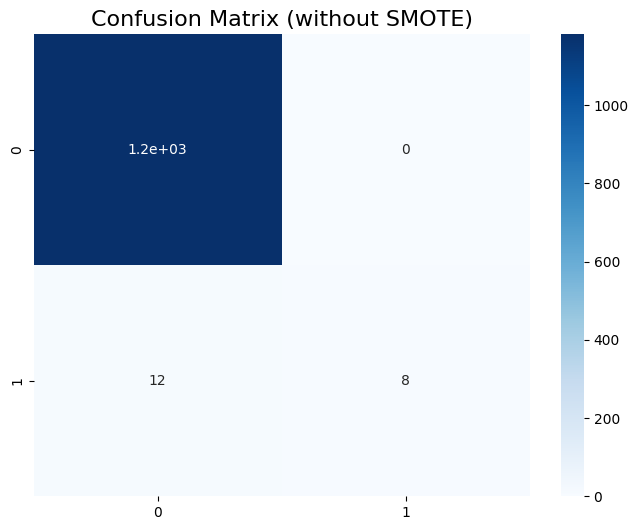

In [181]:
## simple RF model, not accounting for class imbalance
## main metric should be recall (TP/TP+FN)
## we want to minimise FN count so as to ensure we identify all TP correctly, hence recall will be metric


# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [182]:
## handle class imbalance

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4803, 27)
Shape of X after SMOTE: (9444, 27)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraud_flag, dtype: float64

Accuracy = 0.99
Recall = 0.99



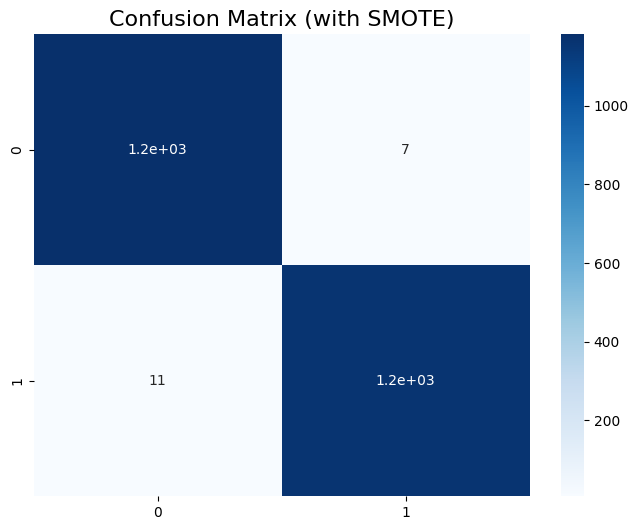

In [183]:
## random forest model with balanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

In [185]:
## feature importance scores

importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) amount                         0.259184
 2) type_PAYMENT                   0.065186
 3) cust_country_UK                0.054732
 4) count_country_JP               0.047096
 5) type_DIVIDEND                  0.047005
 6) type_INTEREST                  0.043502
 7) ccy_CNY                        0.038917
 8) ccy_USD                        0.037231
 9) cust_country_US                0.035012
10) type_INVESTMENT                0.027202
11) type_OTHER                     0.026739
12) ccy_GBP                        0.026045
13) count_country_CN               0.025877
14) ccy_HKD                        0.023911
15) type_TRANSFER                  0.023700
16) ccy_SGD                        0.022445
17) type_TT                        0.021074
18) count_country_IN               0.020616
19) ccy_JPY                        0.020093
20) count_country_DE               0.019620
21) count_country_SG               0.019530
22) count_country_UK               0.019375
23) count_country_HK            

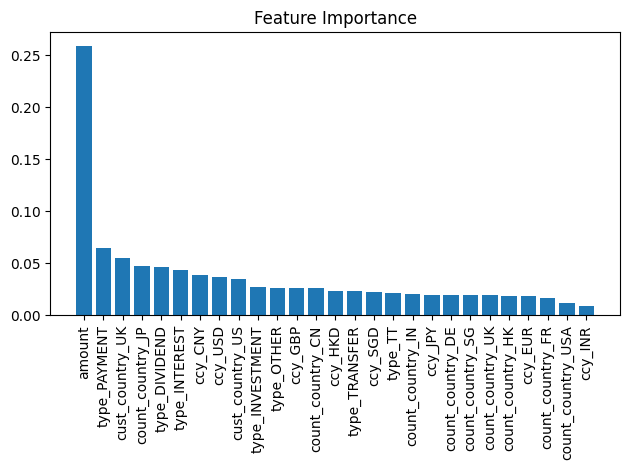

In [186]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()